In [2]:
#import libraries
import torch
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

## Load in and Visualize Dataset

In [63]:
#load data

batch_size = 128

dataset = datasets.MNIST('gan-mnist/data', train=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [64]:
data = iter(dataloader)
images, labels = data.next()

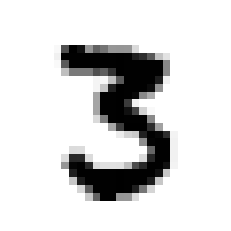

In [69]:
#display an instance
plt.imshow(images[1].squeeze(), cmap='gray_r')
plt.axis('off')
plt.show()

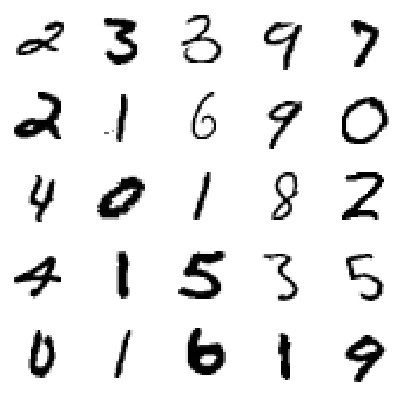

In [70]:
#display some examples from  dataset
plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(images[i].squeeze(), cmap='gray_r')
plt.show()

## Define Dicriminator

In [71]:
import torch.nn as nn
import torch.nn.functional as F

In [72]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #in 1*28*28
        self.conv1 = nn.Conv2d(1,64, 4, stride=2, padding=1)
        #out 64*14*14
        self.conv2 = nn.Conv2d(64,64, 4, stride=2, padding=1)
        #out 64*7*7
        self.output = nn.Linear(64*7*7,1) #linear layer
        
        self.dropout = nn.Dropout(0.4)                        #remember to use model.eval() in test time
        
    def forward(self,x):
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.dropout(out)
        #flatten
        out = out.view(-1,64*7*7)
        #fully connected
        out = self.output(out)
        
        return out

## Define Generator

In [73]:
class Generator(nn.Module):
    def __init__(self, latent_z):
        super(Generator, self).__init__()
        #define fully connected layer
        self.fc = nn.Linear(latent_z, 7*7*128)
        #define transpose convolutional layers
        self.tconv1 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        #out 128*14*14
        self.tconv2 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        #out 128*28*28
        self.conv_output = nn.Conv2d(128, 1, 7, stride=1, padding=3)
        #out 1*28*28
        
    def forward(self,x):
        out = F.leaky_relu(self.fc(x), 0.2)
        
        #reshape into a 128*7*7 tensor
        out = out.view(-1, 128,7,7)       #(batch_size, channels, H, W)
        
        out = F.leaky_relu(self.tconv1(out), 0.2)
        out = F.leaky_relu(self.tconv2(out), 0.2)
        out = F.sigmoid(self.conv_output(out))
        
        return out

## Define Losses 

**GPU Training**

In [74]:
#check wheteher to train on gpu
train_on_gpu = torch.cuda.is_available()

In [78]:
def real_loss(d_out):
    batch_size = d_out.size(0)
    
    #generate lables
    labels = torch.ones(batch_size)
    
    #move labels to gpu if available
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    return loss

def fake_loss(d_out):
    batch_size = d_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    return loss

## Instantiate Models

In [79]:
#hyperparameters
latent_dim = 100

D = Discriminator()
G = Generator(latent_dim)

if train_on_gpu:
    D.cuda()
    G.cuda()

print(D)
print()
print(G)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output): Linear(in_features=3136, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=6272, bias=True)
  (tconv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tconv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_output): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)


## Define Optimization Strategy

In [80]:
import torch.optim as optim

lr = 0.0002

d_optimizer = optim.Adam(D.parameters(), lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(0.5, 0.999))

## Training 

In [6]:
#plotting function
def plot(latent,epoch):
    '''given latent points this fn will generate and plot images 
    '''
    G.eval()
    syn_images = G(latent)
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.axis('off')
        plt.imshow(syn_images[i].detach().cpu().squeeze(), cmap='gray_r')
    plt.show()
    filename = f'generated plot epoch {epoch}'
    plt.savefig(filename)
    plt.close()
    G.train()

In [83]:
import numpy as np

#hyperparametrs 
epochs = 100
show_every = 300

losses = []
samples = []

#create a fized latent vectors for evaluating the model 
fixed_z = np.random.randn(100,100)
fixed_z = torch.from_numpy(fixed_z).float()
if train_on_gpu:
    fixed_z = fixed_z.gpu()


for e in range(epochs):
    G.train()
    
    for i, (real_images, _) in enumerate(dataloader):
        
        batch_size = real_images.size(0)
        
        #move images to gpu if available
        if train_on_gpu:
            real_images = real_images.cuda()
            
            #train discriminator
            d_optimizer.zero_grad()
            # 1.On real data
            d_r_out = D(real_images)
            d_r_loss = real_loss(d_r_out)
            
            # 2.on fake data
            latent = np.random.randn(batch_size, latent_dim)
            latent = torch.from_numpy(latent).float()
            if train_on_gpu:
                latent = latent.cuda()
            #generate fake images
            fake_images = G(latent)
            
            d_f_out = D(fake_images)
            d_f_loss = fake_loss(d_f_out)
            
            #add up losses 
            d_loss = d_r_loss + d_f_loss
            
            #backpropagete
            d_loss.backward()
            #optimize the discriminator
            d_optimizer.step()
            
            
            #train generator 
            g_optimizer.zero_grad()
            
            latent = np.random.randn(batch_size, latent_dim)
            latent = torch.from_numpy(latent).float()
            if train_on_gpu:
                latent = latent.cuda()
            fake_images = G(latent)
            
            g_f_out = D(fake_images)
            g_loss = real_loss(g_f_out)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            if i%show_every == 0:
                print(f'Epoch: {e}\t d_loss: {d_loss.item()}\t g_loss: {g_loss.item()}')
                losses.append((d_loss.item(), g_loss.item()))
        
        if e%5 ==0:
            #plot fixed latent points per every 5 epochs
            plot(fixed_z, e)

In [ ]:
# torch.save(D.state_dict(), 'D.pth')
# torch.save(G.state_dict(), 'G.pth')

In [ ]:
# g_state_dict = torch.load('G.pth')

In [ ]:
# G.load_state_dict(g_state_dict)

In [ ]:
losses_array = np.array(losses)

plt.plot(losses_array[:,0], label='d_loss')
plt.plot(losses_array[:,1], label='g_loss')
plt.legend()
plt.show()

In [ ]:
z = np.random.randn(100,100)
z = torch.from_numpy(z).float()
z = z.cuda()

In [ ]:
G.eval()
gen_images = G(z)

In [ ]:
plt.imshow(G(z)[0].detach().cpu().squeeze())

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(gen_images[i].detach().cpu().squeeze(), cmap='gray')